Objetivo:
- Calcular TPR y PPV para imagenes con y sin overlap
- Calcular OKS para el punto de spine_3 o spine_4 en comparación con el punto central de la elipse


In [617]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

"df" dataFrame de los blobs detectados para las 110 imágenes con threshold en 49 y max_defect_threshold en 12


In [618]:
#file_name = r'C:\Users\inges\OneDrive - UDIT\src\photoneu\no_labels_test_42.csv'
file_name = r'C:\Users\inges\OneDrive - UDIT\src\photoneu\photoneu\raspberryPi-v1\src\logs\no_labels_test_49.csv'
df = pd.DataFrame() 
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,img_path,num_mice,num_blobs,num_inter_points,overlaps,mus_1_x,mus_2_x,mus_3_x,mus_1_y,mus_2_y,mus_3_y,mus_1_area,mus_2_area,mus_3_area
0,0,/img00.png,3,3,2,1,101,135,312.0,234,192,66.0,1050,2529,2912.0
1,1,/img0000.png,3,4,0,0,217,29,129.0,207,143,88.0,3024,3115,2925.0
2,2,/img0001.png,3,4,0,0,306,79,254.0,170,164,118.0,2141,2890,2787.0
3,3,/img0002.png,3,3,2,1,93,64,33.0,226,48,20.0,2740,2204,2581.0
4,4,/img0003.png,3,4,0,0,27,287,79.0,210,219,60.0,2581,2380,1916.0


"df_test" DataFrame con los datos de las etiquetas de las imagenes de Tri-mice

In [619]:
test_file = r'C:\Users\inges\OneDrive - UDIT\src\photoneu\dataset\deeplabcut\labeled-data-ordered\CollectedData_dlc.csv'
df_test = pd.DataFrame()
df_test = pd.read_csv(test_file)
df_test.head()

,scorer,dlc,dlc.1,dlc.2,dlc.3,dlc.4,dlc.5,dlc.6,dlc.7,dlc.8,...,dlc.62,dlc.63,dlc.64,dlc.65,dlc.66,dlc.67,dlc.68,dlc.69,dlc.70,dlc.71
0,individuals,mus1,mus1,mus1,mus1,mus1,mus1,mus1,mus1,mus1,...,mus3,mus3,mus3,mus3,mus3,mus3,mus3,mus3,mus3,mus3
1,bodyparts,snout,snout,leftear,leftear,rightear,rightear,shoulder,shoulder,spine1,...,spine4,spine4,tailbase,tailbase,tail1,tail1,tail2,tail2,tailend,tailend
2,coords,x,y,x,y,x,y,x,y,x,...,x,y,x,y,x,y,x,y,x,y
3,/img0038.png,577.0738982187231,251.0082247294906,575.3425399593766,273.5158821009952,596.5516786363714,272.65020297132196,586.1635290802924,281.7398338328911,586.1635290802924,...,NaN,NaN,NaN,NaN,NaN,NaN,127.01268085145685,332.08101456949316,162.72616092026604,331.8041658867892
4,/img0303.png,608.6823002384388,64.52077380905499,599.5926693768697,72.7840745922997,613.6402807083857,86.00535584549127,599.1795043377074,84.35269568884232,592.5688637111116,...,98.23955027247223,106.37117408591845,114.9010628721575,116.01731295942045,139.16256367520796,127.41729526446827,164.88560067121327,155.47879016920132,177.74711916921592,185.29412850548022


Adaptación de los datos del dataset hacia el formato de no_label_test


In [620]:
def compute_euclidean_distances(df):
    # Elimina filas con NaNs en cualquiera de las 4 columnas relevantes
    clean_df = df.dropna(subset=['xs1', 'ys1', 'xs2', 'ys2'])

    # Calcula distancia euclidiana por fila
    distances = np.sqrt(
        (clean_df['xs1'] - clean_df['xs2'])**2 +
        (clean_df['ys2'] - clean_df['ys2'])**2
    )

    return distances

In [ ]:
#field = 'spine2'

xs1 = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == 'spine1') & (df_test.iloc[2] == 'x')].dropna()
xs2 = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == 'spine2') & (df_test.iloc[2] == 'x')].dropna()
ys1 = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == 'spine1') & (df_test.iloc[2] == 'y')].dropna()
ys2 = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == 'spine2') & (df_test.iloc[2] == 'y')].dropna()

df_k = pd.DataFrame()
df_k['xs1'] = xs1.loc[3:,:].astype(float) #xs1.values[0][3:]
df_k['xs2'] = xs2.loc[3:,:].astype(float) #xs1.values[0][3:]
df_k['ys1'] = ys1.loc[3:,:].astype(float) #xs1.values[0][3:]
df_k['ys2'] = ys2.loc[3:,:].astype(float) #xs1.values[0][3:]
d = np.sqrt((df_k['xs1'] - df_k['xs2'])**2 + (df_k['ys1'] - df_k['ys2'])**2)
#d.mean()/np.sqrt(1500)


0.4326372526500939

In [622]:
d

3      16.038444
4      15.022399
5      17.325313
6      15.832749
7      17.333055
         ...    
110    18.758854
111    11.835957
112    14.439037
113    17.200471
114    16.758227
Length: 112, dtype: float64

"df_clean", reajusta el formato de df_test para tomar las coordenadas de spine2

In [665]:
field = 'spine2'
df_clean = pd.DataFrame()
df_clean["img_path"] = df_test["scorer"]
df_clean.drop([0,1,2], inplace=True)
col = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'x')]
df_clean["mus_1_x"] = col
col = df_test.loc[:, (df_test.iloc[0] == 'mus1') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'y')]
df_clean["mus_1_y"] = col
col = df_test.loc[:, (df_test.iloc[0] == 'mus2') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'x')]
df_clean["mus_2_x"] = col
col = df_test.loc[:, (df_test.iloc[0] == 'mus2') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'y')]
df_clean["mus_2_y"] = col
col = df_test.loc[:, (df_test.iloc[0] == 'mus3') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'x')]
df_clean["mus_3_x"] = col
col = df_test.loc[:, (df_test.iloc[0] == 'mus3') & (df_test.iloc[1] == field) & (df_test.iloc[2] == 'y')]
df_clean["mus_3_y"] = col

df_clean.head()

,img_path,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
3,/img0038.png,585.2978499506191,313.337122065965,96.94862418821859,320.6372283383545,45.34231945379248,398.52469841844044
4,/img0303.png,584.7187279670292,109.96892811690094,118.75671058567993,338.86136203326316,69.30113365196624,85.0327456687777
5,/img0502.png,410.0330142199049,165.77297981195258,527.4234560583649,422.39847716466613,69.59278316255637,81.44858111374327
6,/img0707.png,296.9066937337021,355.91583112359655,515.3951513434035,163.80427650680974,179.03600191344594,257.6735605374612
7,/img1138.png,258.2955342228739,251.30563319809525,338.64128124234094,220.5852005141814,586.6833164856594,107.48222265721671


Reajusta las filas de df_clean para que estén ordenadas por la columna 'img_path' como en 'df'

In [625]:
df_clean = df_clean.set_index('img_path').reindex(df['img_path']).reset_index()
df_clean.head()

,img_path,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
0,/img00.png,285.862,361.662,221.247,452.862,603.968,168.872
1,/img0000.png,64.28522329782527,275.991415240743,241.55273818664858,216.7859572152694,455.07940066362625,393.90859173140313
2,/img0001.png,155.77390569322546,316.80287821336435,506.5145689924103,269.23254111642325,596.9672384853243,345.0584722366484
3,/img0002.png,135.63383132968343,136.74439337827795,189.31332168073828,430.05871315123414,72.29070323306453,97.96206006209573
4,/img0003.png,74.50227931400084,404.8255917447581,173.3370296202873,172.68954525955252,572.0793269934234,405.09571343657643


In [626]:
#cols = df_clean.filter(like = 'mus')
#df_clean[cols.columns][~np.isnan(df_clean[cols.columns])]/2

#df_clean[cols.columns] = df_clean.filter(like = 'mus').div(2)
df_clean.head()

,img_path,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
0,/img00.png,285.862,361.662,221.247,452.862,603.968,168.872
1,/img0000.png,64.28522329782527,275.991415240743,241.55273818664858,216.7859572152694,455.07940066362625,393.90859173140313
2,/img0001.png,155.77390569322546,316.80287821336435,506.5145689924103,269.23254111642325,596.9672384853243,345.0584722366484
3,/img0002.png,135.63383132968343,136.74439337827795,189.31332168073828,430.05871315123414,72.29070323306453,97.96206006209573
4,/img0003.png,74.50227931400084,404.8255917447581,173.3370296202873,172.68954525955252,572.0793269934234,405.09571343657643


In [627]:
df.head()

,Unnamed: 0,img_path,num_mice,num_blobs,num_inter_points,overlaps,mus_1_x,mus_2_x,mus_3_x,mus_1_y,mus_2_y,mus_3_y,mus_1_area,mus_2_area,mus_3_area
0,0,/img00.png,3,3,2,1,101,135,312.0,234,192,66.0,1050,2529,2912.0
1,1,/img0000.png,3,4,0,0,217,29,129.0,207,143,88.0,3024,3115,2925.0
2,2,/img0001.png,3,4,0,0,306,79,254.0,170,164,118.0,2141,2890,2787.0
3,3,/img0002.png,3,3,2,1,93,64,33.0,226,48,20.0,2740,2204,2581.0
4,4,/img0003.png,3,4,0,0,27,287,79.0,210,219,60.0,2581,2380,1916.0


In [661]:
df['mus_1_area'] = df['mus_1_area'].astype(float)
k = d.mean()/np.sqrt(df['mus_1_area'].mean())
k

0.34491098481338156

dataframe de no_labels_test que se queda solamente con las coordenadas de los centros de las elipses, así como las áreas


In [628]:
df_nums = df.filter(like='mus')*2
#df_nums = df.filter(like='mus')

In [629]:
df_nums.head()

,mus_1_x,mus_2_x,mus_3_x,mus_1_y,mus_2_y,mus_3_y,mus_1_area,mus_2_area,mus_3_area
0,202,270,624.0,468,384,132.0,2100,5058,5824.0
1,434,58,258.0,414,286,176.0,6048,6230,5850.0
2,612,158,508.0,340,328,236.0,4282,5780,5574.0
3,186,128,66.0,452,96,40.0,5480,4408,5162.0
4,54,574,158.0,420,438,120.0,5162,4760,3832.0


In [630]:
df_clean_nums = pd.DataFrame()
df_clean_nums = df_clean.drop('img_path', axis=1)

In [631]:
df_clean_nums.dtypes

mus_1_x    object
mus_1_y    object
mus_2_x    object
mus_2_y    object
mus_3_x    object
mus_3_y    object
dtype: object

In [632]:
df_clean_nums.describe()

,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
count,112,112,112,112,112,112
unique,106,102,104,104,102,101
top,423.544,179.172,491.908,205.107,62.325,357.207
freq,3,3,3,4,3,4


In [633]:
df_clean_nums.dropna(axis = 1, how='all').describe()

,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
count,112,112,112,112,112,112
unique,106,102,104,104,102,101
top,423.544,179.172,491.908,205.107,62.325,357.207
freq,3,3,3,4,3,4


In [634]:
df_clean_nums.isnull().sum()/len(df_clean_nums)*100

mus_1_x    0.884956
mus_1_y    0.884956
mus_2_x    0.884956
mus_2_y    0.884956
mus_3_x    0.884956
mus_3_y    0.884956
dtype: float64

In [635]:
df_clean_nums['mus_3_y'] = df_clean_nums['mus_3_y'].fillna(0)

In [636]:
df_clean_nums.isnull().sum()

mus_1_x    1
mus_1_y    1
mus_2_x    1
mus_2_y    1
mus_3_x    1
mus_3_y    0
dtype: int64

In [637]:
df_clean_nums = df_clean_nums.fillna(0)

In [638]:
#np.isinf(df_clean_nums).values.sum()

In [639]:
df.isnull().sum()

Unnamed: 0          0
img_path            0
num_mice            0
num_blobs           0
num_inter_points    0
overlaps            0
mus_1_x             0
mus_2_x             0
mus_3_x             1
mus_1_y             0
mus_2_y             0
mus_3_y             1
mus_1_area          0
mus_2_area          0
mus_3_area          1
dtype: int64

In [640]:
df = df.fillna(0)

In [641]:
#df_nums = pd.DataFrame()
#df_nums = df.drop('img_path', axis=1).astype('int32')

Una vez los datos ground_truth en df_clean_nums
y los datos medidos en df, 
pasamos a analizar las distintas métricas

In [642]:
df_clean_nums = df_clean_nums.astype('float16')
df_clean_nums.dtypes

mus_1_x    float16
mus_1_y    float16
mus_2_x    float16
mus_2_y    float16
mus_3_x    float16
mus_3_y    float16
dtype: object

In [643]:
df_clean_nums.describe()

c:\ProgramData\anaconda3\envs\DEEPLABCUT\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\DEEPLABCUT\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\DEEPLABCUT\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\DEEPLABCUT\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\DEEPLABCUT\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
count,113.0,113.000,113.00,113.000,113.0000,113.00
mean,299.0,226.750,361.25,266.500,251.3750,268.75
std,inf,105.750,inf,inf,inf,inf
min,0.0,0.000,0.00,0.000,0.0000,0.00
25%,129.5,158.125,220.00,198.500,64.5625,157.50
50%,361.5,180.250,406.75,220.625,150.2500,339.75
75%,415.5,279.500,501.25,360.750,475.2500,356.75
max,598.0,448.750,615.00,452.750,608.0000,443.75


In [644]:
df_clean_nums.head()

,mus_1_x,mus_1_y,mus_2_x,mus_2_y,mus_3_x,mus_3_y
0,285.7500,361.75,221.250,452.75,604.0000,168.8750
1,64.3125,276.00,241.500,216.75,455.0000,394.0000
2,155.7500,316.75,506.500,269.25,597.0000,345.0000
3,135.6250,136.75,189.375,430.00,72.3125,97.9375
4,74.5000,404.75,173.375,172.75,572.0000,405.0000


In [645]:
df_nums.describe()

,mus_1_x,mus_2_x,mus_3_x,mus_1_y,mus_2_y,mus_3_y,mus_1_area,mus_2_area,mus_3_area
count,113.000000,113.000000,112.000000,113.000000,113.000000,112.000000,113.000000,113.000000,112.000000
mean,198.778761,336.017699,378.696429,358.955752,220.584071,134.339286,4720.141593,4967.079646,4901.625000
std,174.012814,180.948591,205.112443,94.473011,109.227051,87.887269,1100.449996,895.505685,1614.616581
min,18.000000,24.000000,20.000000,136.000000,8.000000,6.000000,924.000000,1918.000000,746.000000
25%,48.000000,180.000000,141.500000,348.000000,140.000000,91.000000,4374.000000,4230.000000,3991.000000
50%,146.000000,368.000000,414.000000,362.000000,174.000000,116.000000,4864.000000,5034.000000,5347.000000
75%,284.000000,502.000000,566.500000,440.000000,286.000000,156.500000,5254.000000,5644.000000,5786.000000
max,622.000000,626.000000,630.000000,472.000000,464.000000,448.000000,7904.000000,7128.000000,11482.000000


In [646]:

#df_results["mus_1_x_error"] = df_nums["mus_3_x"] - df_clean_nums["mus_1_x"]
#df_results

No hay una correspondencia entre los IDs (1,2,3) de los ratones, entre el dataset df_clean (ground-truth) y el de la percepción, df (no_labels), que además será distinto en cada imagen...

Así que se calcula la diferencia y nos quedamos con el mínimo

In [647]:
df_results = pd.DataFrame()

for i in range(1,4):
    for j in range(1,4):
            col_name = f"error_x_{i}_{j}"
            col_name_df = f"mus_{i}_x"
            col_name_clean = f"mus_{j}_x"
            df_results[col_name] = abs(df_nums[col_name_df] - df_clean_nums[col_name_clean])

for i in range(1,4):
    for j in range(1,4):
            col_name = f"error_y_{i}_{j}"
            col_name_df = f"mus_{i}_y"
            col_name_clean = f"mus_{j}_y"
            df_results[col_name] = abs(df_nums[col_name_df] - df_clean_nums[col_name_clean])

#for i in range(1,4):
#    for j in range(1,4):
#            col_2_name = f"error_x2_{i}_{j}"
#            df_results[col_2_name] = np.power((df_nums[col_name_df] - df_clean_nums[col_name_clean]),2)
#
#for i in range(1,4):
#    for j in range(1,4):
#            col_2_name = f"error_y2_{i}_{j}"
#            df_results[col_2_name] = np.power((df_nums[col_name_df] - df_clean_nums[col_name_clean]),2)
df_results.head()

,error_x_1_1,error_x_1_2,error_x_1_3,error_x_2_1,error_x_2_2,error_x_2_3,error_x_3_1,error_x_3_2,error_x_3_3,error_y_1_1,error_y_1_2,error_y_1_3,error_y_2_1,error_y_2_2,error_y_2_3,error_y_3_1,error_y_3_2,error_y_3_3
0,83.7500,19.250,402.0000,15.7500,48.750,334.0000,338.2500,402.750,20.0000,106.25,15.25,299.1250,22.25,68.75,215.1250,229.75,320.75,36.8750
1,369.6875,192.500,21.0000,6.3125,183.500,397.0000,193.6875,16.500,197.0000,138.00,197.25,20.0000,10.00,69.25,108.0000,100.00,40.75,218.0000
2,456.2500,105.500,15.0000,2.2500,348.500,439.0000,352.2500,1.500,89.0000,23.25,70.75,5.0000,11.25,58.75,17.0000,80.75,33.25,109.0000
3,50.3750,3.375,113.6875,7.6250,61.375,55.6875,69.6250,123.375,6.3125,315.25,22.00,354.0625,40.75,334.00,1.9375,96.75,390.00,57.9375
4,20.5000,119.375,518.0000,499.5000,400.625,2.0000,83.5000,15.375,414.0000,15.25,247.25,15.0000,33.25,265.25,33.0000,284.75,52.75,285.0000


In [648]:
#df_results = df_results.drop(['mus_1_x_error'], axis=1)

In [649]:
df_results.describe()

,error_x_1_1,error_x_1_2,error_x_1_3,error_x_2_1,error_x_2_2,error_x_2_3,error_x_3_1,error_x_3_2,error_x_3_3,error_y_1_1,error_y_1_2,error_y_1_3,error_y_2_1,error_y_2_2,error_y_2_3,error_y_3_1,error_y_3_2,error_y_3_3
count,113.00000,113.000000,113.000000,113.000000,113.000000,113.000000,112.000000,112.000000,112.000000,113.00000,113.00000,113.000000,113.000000,113.000000,113.000000,112.000000,112.000000,112.000000
mean,176.70354,237.426438,135.302268,104.791482,102.619469,233.221515,164.011440,144.776228,208.821150,142.92865,101.21792,104.512168,49.324668,85.824115,109.269912,100.107701,134.126116,138.329241
std,164.48602,208.731025,161.224420,133.024869,145.161447,184.360058,187.633481,158.223171,181.391935,100.37857,87.26558,120.615158,63.815210,89.978538,85.273679,92.344831,115.444501,95.169988
min,1.00000,0.500000,0.500000,2.250000,0.000000,0.125000,0.000000,1.500000,1.000000,0.25000,0.75000,0.500000,0.437500,0.125000,0.750000,0.125000,2.500000,2.500000
25%,16.65625,18.750000,15.093750,13.500000,3.062500,33.375000,8.500000,13.437500,16.812500,43.00000,19.00000,14.750000,15.250000,28.437500,40.125000,39.500000,40.500000,50.765625
50%,107.00000,192.500000,39.750000,78.750000,48.750000,252.500000,81.500000,86.125000,214.000000,173.50000,79.25000,31.250000,22.750000,38.750000,87.750000,66.000000,90.000000,109.375000
75%,361.75000,452.000000,243.937500,133.343750,101.750000,437.687500,277.687500,287.218750,352.125000,208.00000,157.50000,221.000000,45.125000,121.500000,176.250000,130.312500,209.687500,231.500000
max,564.00000,571.000000,552.500000,544.484375,554.562500,557.000000,600.484375,539.500000,555.906250,392.00000,392.00000,392.000000,309.750000,432.250000,359.250000,372.500000,413.750000,395.250000


In [650]:
min_values = []
for index, row in df_results.iterrows():
    row_min = []
    for i in range(0,len(row), 3):
        row_min.append(row[i:i+3].min())
    min_values.append(row_min)
#err_df = pd.DataFrame(min_values, columns=['err_x_1', 'err_x_2', 'err_x_3','err_y_1', 'err_y_2', 'err_y_3','err2_x_1', 'err2_x_2', 'err2_x_3','err2_y_1', 'err2_y_2', 'err2_y_3'])
err_df = pd.DataFrame(min_values, columns=['err_x_1', 'err_x_2', 'err_x_3','err_y_1', 'err_y_2', 'err_y_3'])
err_df.head()
err_df.describe()

,err_x_1,err_x_2,err_x_3,err_y_1,err_y_2,err_y_3
count,113.000000,113.000000,112.000000,113.000000,113.000000,112.000000
mean,12.754563,10.010232,12.581334,16.934735,17.957965,37.113281
std,14.167619,16.944049,33.058464,36.691577,14.465311,18.308910
min,0.500000,0.000000,0.000000,0.250000,0.125000,0.125000
25%,5.750000,2.250000,5.000000,6.750000,8.875000,28.890625
50%,13.187500,8.625000,8.000000,14.750000,15.625000,39.750000
75%,16.312500,13.250000,13.062500,19.250000,22.687500,44.531250
max,146.000000,174.000000,352.000000,392.000000,104.000000,129.250000


Calculo de OKS = exp (-di^2/(2s^2 ki^2))
Con di^2 = err2_x + err2_y

In [662]:
k = 0.107  # según COCO para las caderas de un ser humano
k = 0.35
# k = 2* dev 
#k= 1.25 # porque hay 8 puntos etiquetados entre el hocico y el comienzo de la cola 
#k = 0.23
#err_df['d2_1'] = err_df['err2_x_1'] + err_df['err2_y_1']
#err_df['d2_2'] = err_df['err2_x_2'] + err_df['err2_y_2']
#err_df['d2_3'] = err_df['err2_x_3'] + err_df['err2_y_3']
err_df['d2_1'] = err_df['err_x_1']**2 + err_df['err_y_1']**2
err_df['d2_2'] = err_df['err_x_2']**2 + err_df['err_y_2']**2
err_df['d2_3'] = err_df['err_x_3']**2 + err_df['err_y_3']**2
err_df['s2_1'] = df['mus_1_area'] #**2
err_df['s2_2'] = df['mus_2_area'] #**2
err_df['s2_3'] = df['mus_3_area'] #**2

oks_1 = err_df['d2_1']/(2*err_df['s2_1']*k**2)
err_df['oks_1'] = np.exp(-oks_1)
oks_2 = err_df['d2_2']/(2*err_df['s2_2']*k**2)
err_df['oks_2'] = np.exp(-oks_2)
oks_3 = err_df['d2_3']/(2*err_df['s2_3']*k**2)
err_df['oks_3'] = np.exp(-oks_3)
err_df.describe()

,err_x_1,err_x_2,err_x_3,err_y_1,err_y_2,err_y_3,d2_1,d2_2,d2_3,s2_1,s2_2,s2_3,oks_1,oks_2,oks_3
count,113.000000,113.000000,112.000000,113.000000,113.000000,112.000000,113.000000,113.000000,112.000000,113.000000,113.000000,113.000000,1.130000e+02,1.130000e+02,1.120000e+02
mean,12.754563,10.010232,12.581334,16.934735,17.957965,37.113281,1982.767122,914.646821,2951.013133,2360.070796,2483.539823,2429.123894,5.130698e-01,5.257054e-01,2.053151e-01
std,14.167619,16.944049,33.058464,36.691577,14.465311,18.308910,16422.928503,3865.700521,11995.793119,550.224998,447.752842,836.111366,2.244216e-01,2.786522e-01,2.934774e-01
min,0.500000,0.000000,0.000000,0.250000,0.125000,0.125000,3.250000,12.828125,20.312500,462.000000,959.000000,0.000000,1.221395e-110,4.240995e-27,4.096435e-84
25%,5.750000,2.250000,5.000000,6.750000,8.875000,28.890625,283.222656,157.812500,1097.312500,2187.000000,2115.000000,1988.000000,3.905325e-01,3.215712e-01,1.294738e-02
50%,13.187500,8.625000,8.000000,14.750000,15.625000,39.750000,366.500000,329.062500,1638.851562,2432.000000,2517.000000,2663.000000,5.216707e-01,5.460714e-01,8.013150e-02
75%,16.312500,13.250000,13.062500,19.250000,22.687500,44.531250,520.844727,723.265625,2143.176758,2627.000000,2822.000000,2890.000000,6.208886e-01,7.333984e-01,1.741512e-01
max,146.000000,174.000000,352.000000,392.000000,104.000000,129.250000,174980.000000,41092.000000,127268.000000,3952.000000,3564.000000,5741.000000,9.944418e-01,9.813152e-01,9.676226e-01


In [657]:
# imputar valores nan en oks con la media de la columna
err_df['oks_1'] = err_df['oks_1'].fillna(err_df['oks_1'].mean())
err_df['oks_2'] = err_df['oks_2'].fillna(err_df['oks_2'].mean())
err_df['oks_3'] = err_df['oks_3'].fillna(err_df['oks_3'].mean())

#imprimir cuántos valores no válidos hay en las columnas oks_1, oks_2 y oks_3
print("null oks_1: ", err_df['oks_1'].isnull().sum())
print("null oks_2: ", err_df['oks_2'].isnull().sum())
print("null oks_3: ", err_df['oks_3'].isnull().sum())


null oks_1:  0
null oks_2:  0
null oks_3:  0


### Métricas según si hay o no solapamiento en la imagen

In [663]:
#tomar los OKS de las filas que tienen overlaps a 1
oks_1 = err_df['oks_1'][df['overlaps'] > 0].mean()
oks_2 = err_df['oks_2'][df['overlaps'] > 0].mean()
oks_3 = err_df['oks_3'][df['overlaps'] > 0].mean()
print(f'OKS 1: {oks_1:.2f}')
print(f'OKS 2: {oks_2:.2f}')
print(f'OKS 3: {oks_3:.2f}')

OKS 1: 0.53
OKS 2: 0.55
OKS 3: 0.26


In [664]:
# tomar los OKS de las filas que tienen overlaps a 0
oks_1 = err_df['oks_1'][df['overlaps'] == 0].dropna().mean()
oks_2 = err_df['oks_2'][df['overlaps'] == 0].mean()
oks_3 = err_df['oks_3'][df['overlaps'] == 0].mean()
print(f'OKS 1: {oks_1:.2f}')
print(f'OKS 2: {oks_2:.2f}')
print(f'OKS 3: {oks_3:.2f}')

OKS 1: 0.48
OKS 2: 0.48
OKS 3: 0.08


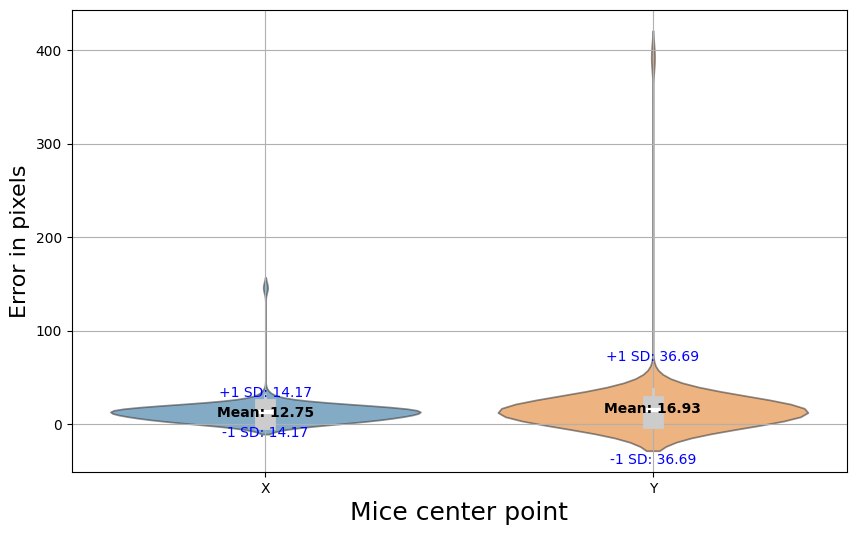

In [539]:
df_min = pd.DataFrame()
df_min.loc[:, 'err_x_1'] = err_df.loc[:, 'err_x_1']
df_min.loc[:, 'err_y_1'] = err_df.loc[:, 'err_y_1']
df_min.head()
# Configurar el gráfico de violín
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_min, alpha=0.6, inner_kws=dict(box_width=15, whis_width=2, color=".8"))  # Crear el diagrama de violín sin la línea interior

# Calcular y etiquetar el valor medio y la desviación estándar para cada columna
for i, col in enumerate(df_min.columns):
    mean = df_min[col].mean()
    std = df_min[col].std()
    
    # Agregar la etiqueta del valor medio
    plt.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    
    # Agregar la etiqueta de la desviación estándar
    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)

# Configurar etiquetas y título
#plt.title('Error de detección entre el centro de la elipse (test) y el punto spine2 (train)')
#plt.xlabel('Posición de los puntos x, y por ratones')
#plt.ylabel('Error en píxeles')
#plt.title('Error between ellipse center (test) and spine2 point (train)')
plt.xticks(np.arange(2),['X','Y'])
plt.xlabel('Mice center point', fontsize=18)
plt.ylabel('Error in pixels',fontsize=16)
#plt.ylim(-15,75)
plt.grid(True)

# Mostrar el gráfico
plt.show()
#frame.shape: 240 x 320

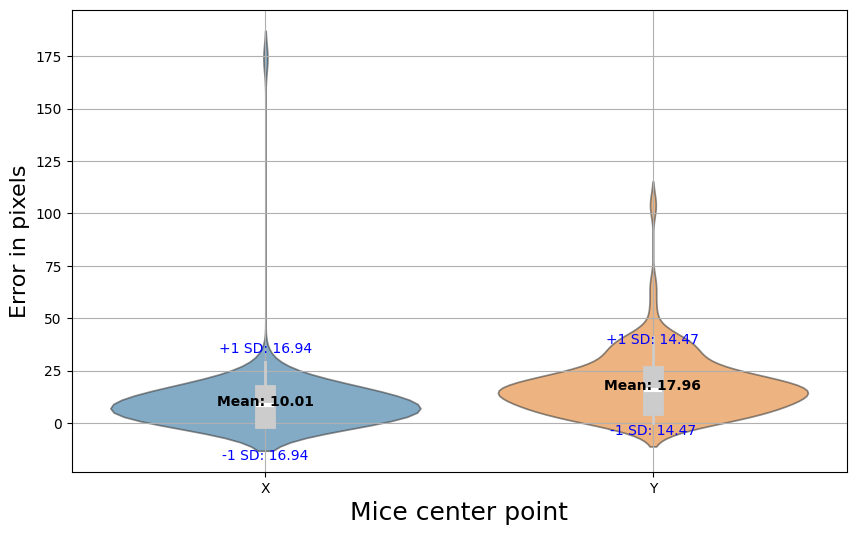

In [540]:
df_min = pd.DataFrame()
df_min.loc[:, 'err_x_2'] = err_df.loc[:, 'err_x_2']
df_min.loc[:, 'err_y_2'] = err_df.loc[:, 'err_y_2']
df_min.head()
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_min, alpha=0.6, inner_kws=dict(box_width=15, whis_width=2, color=".8"))  # Crear el diagrama de violín sin la línea interior
for i, col in enumerate(df_min.columns):
    mean = df_min[col].mean()
    std = df_min[col].std()
    
    # Agregar la etiqueta del valor medio
    plt.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    
    # Agregar la etiqueta de la desviación estándar
    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)

plt.xticks(np.arange(2),['X','Y'])
plt.xlabel('Mice center point', fontsize=18)
plt.ylabel('Error in pixels',fontsize=16)
plt.grid(True)
plt.show()


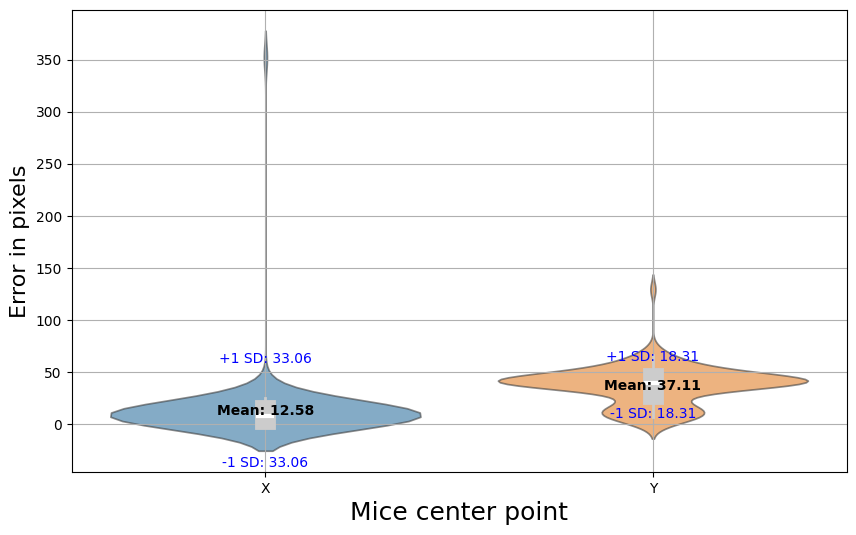

In [541]:
df_min = pd.DataFrame()
df_min.loc[:, 'err_x_3'] = err_df.loc[:, 'err_x_3']
df_min.loc[:, 'err_y_3'] = err_df.loc[:, 'err_y_3']
df_min.head()
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_min, alpha=0.6, inner_kws=dict(box_width=15, whis_width=2, color=".8"))  # Crear el diagrama de violín sin la línea interior
for i, col in enumerate(df_min.columns):
    mean = df_min[col].mean()
    std = df_min[col].std()
    
    # Agregar la etiqueta del valor medio
    plt.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    
    # Agregar la etiqueta de la desviación estándar
    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
plt.xticks(np.arange(2),['X','Y'])
plt.xlabel('Mice center point', fontsize=18)
plt.ylabel('Error in pixels',fontsize=16)
plt.grid(True)
plt.show()

    Cálculo de otras métricas de performance:
- True Positive Rate, TPR:
TPR = TP / (TP + FN)
- Positive Predicted Value:
PPV = TP / (TP + FP)

    En donde:
- TP: numero de ratones correctamente detectados. Es el número total de ratones detectados: 339
- FN: False Negative. Ratones que no se detectaron correctamente.
- TP + FN: número total de ratones: 3x112 = 336 

In [542]:
TP = 335
N_MICES = 3*113
TPR = TP/ N_MICES
print(f'True Positive Rate: {TPR:.3f}')

True Positive Rate: 0.988


In [543]:
TP = 335
FP = 4
PPV = TP/ (TP + FP)
print(f'Positive Predicted Value: {PPV:.3f}')

Positive Predicted Value: 0.988


In [544]:
err_df.head()

,err_x_1,err_x_2,err_x_3,err_y_1,err_y_2,err_y_3,d2_1,d2_2,d2_3,s2_1,s2_2,s2_3,oks_1,oks_2,oks_3
0,19.250,15.7500,20.0000,15.25,22.2500,36.8750,603.125000,743.125000,1759.765625,1050,2529,2912.0,0.832094,0.910256,0.824168
1,21.000,6.3125,16.5000,20.00,10.0000,40.7500,841.000000,139.847656,1932.812500,3024,3115,2925.0,0.914850,0.985736,0.809407
2,15.000,2.2500,1.5000,5.00,11.2500,33.2500,250.000000,131.625000,1107.812500,2141,2890,2787.0,0.963324,0.985531,0.880560
3,3.375,7.6250,6.3125,22.00,1.9375,57.9375,495.390625,61.894531,3396.601562,2740,2204,2581.0,0.943786,0.991054,0.656311
4,20.500,2.0000,15.3750,15.00,33.0000,52.7500,645.250000,1093.000000,3018.953125,2581,2380,1916.0,0.923116,0.863330,0.603983


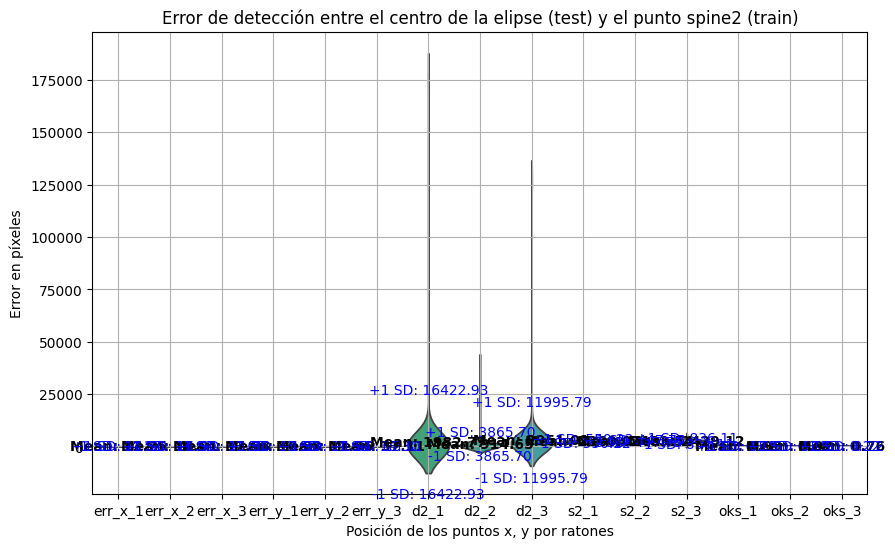

In [545]:
df_min = err_df
# Configurar el gráfico de violín
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_min, inner=None)  # Crear el diagrama de violín sin la línea interior

# Calcular y etiquetar el valor medio y la desviación estándar para cada columna
for i, col in enumerate(df_min.columns):
    mean = df_min[col].mean()
    std = df_min[col].std()
    
    # Agregar la etiqueta del valor medio
    plt.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    
    # Agregar la etiqueta de la desviación estándar
    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)

# Configurar etiquetas y título
plt.title('Error de detección entre el centro de la elipse (test) y el punto spine2 (train)')
plt.xlabel('Posición de los puntos x, y por ratones')
plt.grid(True)
plt.ylabel('Error en píxeles')

# Mostrar el gráfico
plt.show()

### OKS con el punto spine_3


### Análisis temporal de latencias

In [546]:
file_name = r'C:\Users\inges\OneDrive - UDIT\src\photoneu\no_labels_test_times.csv'
df = pd.DataFrame() 
df = pd.read_csv(file_name)

df.drop(df.columns[0], axis=1, inplace=True)
df = df*1000
df.head()

,t_init_resize,t_gray_norm,t_blur,t_thres,t_erosion,t_opening,t_blobs
0,26.019339,0.470532,1.692887,0.066333,0.345736,0.591215,8.332068
1,14.279904,0.330255,2.362139,0.093740,0.496272,0.627807,1.999180
2,167.145404,0.368626,1.733664,0.056777,0.287682,0.590864,2.219825
3,97.301956,0.330347,1.674444,0.045740,0.276756,0.638233,2.041679
4,208.272416,0.322403,1.715110,0.053166,0.289904,0.606529,2.074624


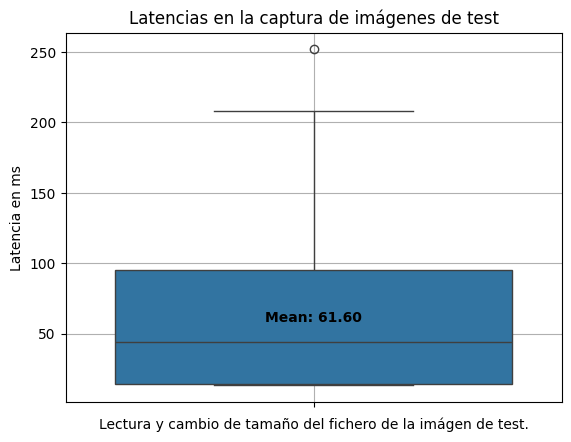

In [547]:
#df_min = df.drop(df.columns[0], axis = 1)
df_min = df
plt.figure()
sns.boxplot(data=df_min[df_min.columns[0]])  # Crear el diagrama de violín sin la línea interior

#for i, col in enumerate(df_min.columns):
mean = df_min[df_min.columns[0]].mean()
std = df_min[df_min.columns[0]].std()
plt.text(0, mean - 0.2, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    
#    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
#    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)

# Configurar etiquetas y título
#plt.ylim(0,5)
plt.title('Latencias en la captura de imágenes de test')
plt.xlabel('Lectura y cambio de tamaño del fichero de la imágen de test.')
plt.grid(True)
plt.ylabel('Latencia en ms')

# Mostrar el gráfico
plt.show()

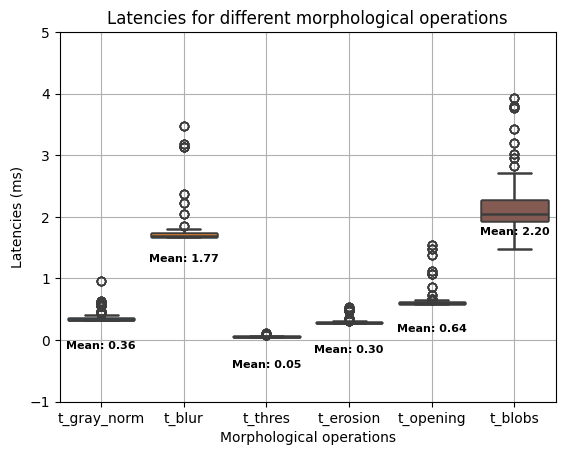

In [548]:
df_min = df.drop(df.columns[0], axis = 1)
#df_min = df
plt.figure()

for i, col in enumerate(df_min.columns):
    mean = df_min[df_min.columns[i]].mean()
    std = df_min[df_min.columns[i]].std()
    sns.boxplot(data=df_min)  # Crear el diagrama de violín sin la línea interior
    plt.text(i, mean - 0.45, f'Mean: {mean:.2f}', ha='center', va='center', color='black', fontsize=8, fontweight='bold')    
#    plt.text(i, mean + 1.5*std, f'+1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)
#    plt.text(i, mean - 1.5*std, f'-1 SD: {std:.2f}', ha='center', va='center', color='blue', fontsize=10)

# Configurar etiquetas y título
plt.ylim(-1,5)
plt.title('Latencies for different morphological operations') 
plt.xlabel('Morphological operations')
#plt.title('Latencias en la captura de imágenes de test')
#plt.xlabel('Lectura y cambio de tamaño del fichero de la imágen de test.')
plt.grid(True)
plt.ylabel('Latencies (ms)')
#plt.ylabel('Latencia en ms')

# Mostrar el gráfico
plt.show()

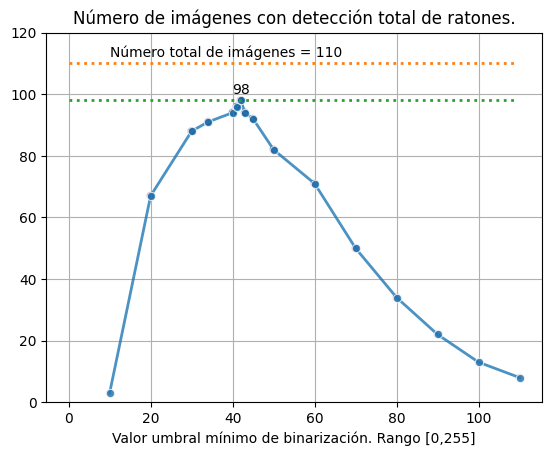

In [549]:
x = [10,20,30,34,40,41,42,43,45,50,60,70,80,90,100,110]
y = [3,67,88,91,94,96,98,94,92,82,71,50,34,22,13,8]
l = 110*np.ones(110)
plt.figure()
sns.scatterplot(x=x, y=y, hue=y, legend=False)
sns.lineplot(x=x, y=y, alpha=0.8, marker='o', linewidth=2)
plt.text(x=10,y=112,s="Número total de imágenes = 110")
plt.plot(l, linestyle = 'dotted', linewidth=2)
l = 98*np.ones(110)
plt.text(x=40,y=100,s="98")
plt.plot(l, linestyle = 'dotted', linewidth=2)
plt.ylim(0,120)

#plt.ylabel('Número de imágenes con detección de 3 ratones')
plt.xlabel(xlabel='Valor umbral mínimo de binarización. Rango [0,255]')
plt.grid(True)
plt.title("Número de imágenes con detección total de ratones.")
plt.show()


In [550]:

m = df['num_mice'].median()
s = df['num_mice'].std()
x = np.random.normal(-0.04,0.04,size=len(df['num_mice']))

print(s)
plt.figure()
sns.boxplot(df['num_mice'],fill=True,)
sns.violinplot(df['num_mice'],fill=True,)
plt.text(x = -0.1, y = 2.8, s="median = " + str(m))
plt.text(x = 0.05, y = 2.2, s=f"std = {s:.2f}" )
plt.plot(x, df['num_mice'], 'r.', alpha=0.4)
plt.title('Mediana de número de ratones detectados por imagen.')
plt.ylabel('Número de ratones')

plt.grid(False)
plt.show()


KeyError: 'num_mice'

In [ ]:
sum(df['num_mice'])

In [ ]:
n = df['num_mice'].astype('category')
plt.figure()
values = n.value_counts()
values.plot(kind='bar', alpha=0.8, color = 'cadetblue')
#plt.title('Mediana de número de ratones detectados por imagen.')
percent = n.value_counts() * 100 / len(n)
for i, v in enumerate(percent):
    plt.text( i, v + 6, s=f'{v:.2f}%'+'\n('+f'{values[3-i]:.0f}' +')', ha='center', va='center', color='maroon', fontsize=10)
l = 110*np.ones(110)
plt.plot(l, linestyle = 'dotted', linewidth=2, color='darkblue')
plt.text(-0.2, 110, "113", ha='center', va='center', color='darkblue', fontsize=10)

plt.ylim(0,114)
plt.xticks(rotation=0)
plt.xlabel('Number of mice')
plt.ylabel('Number of images')

plt.grid(True)
plt.show()


In [ ]:
print(n.value_counts())
print(len(n))
print(n.value_counts() * 100 / len(n))